In [ ]:
import sys

sys.path.insert(1, "../")

In [1]:
from em_algo.models import WeibullModelExp, GaussianModel, ExponentialModel, Model
from em_algo.utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from test_utils import *

results = open_results("big_weibull_gauss_test")
results += open_results("big_exponential_test")

In [3]:
result_by_model: dict[type[Model], list[TestResult]] = dict()

for result in results:
    model = result.test.base_distributions[0].model
    if not model in result_by_model:
        result_by_model[model] = []
    result_by_model[model].append(result)

In [4]:
def occur(X: Params, distributions: list[Distribution]):
    return np.sum([
        np.log(np.sum([
            d.prior_probability * d.model.p(x, d.params)
            if (d.prior_probability is not None) and np.isfinite(d.prior_probability)
            else 0
            for d in distributions
        ])) for x in X]) / len(X)

In [5]:
results_data: dict[type[Model], pd.DataFrame] = {}

for model in result_by_model.keys():
    rslts = result_by_model[model]
    r_bk: dict[int, list[TestResult]] = dict()
    for r in rslts:
        k = r.test.k
        if k not in r_bk:
            r_bk[k] = []
        r_bk[k].append(r)

    x = [1, 2, 3, 4, 5]
    y = {50: {}, 100: {}, 200: {}, 500: {}}

    data = []

    for k in x:
        r = r_bk[k]
        success = {50: 0, 100: 0, 200: 0, 500: 0}
        all = {50: 0, 100: 0, 200: 0, 500: 0}
        steps = {50: [], 100: [], 200: [], 500: []}
        for _r in r:
            if (_r.test.max_step > _r.result.steps):
                if (_r.result.error is None):
                    success[len(_r.test.data)] += 1
                steps[len(_r.test.data)].append((_r.result.steps, _r.time))
            all[len(_r.test.data)] += 1

        for size in success.keys():
            for step in steps[size]:
                dt = {}
                dt["k"] = k
                dt["size"] = size
                dt["success"] = success[size] / all[size] * 100
                dt["steps"] = step[0]
                dt["time"] = step[1]
                data.append(dt)

    data = pd.DataFrame(data)

    results_data[model] = data

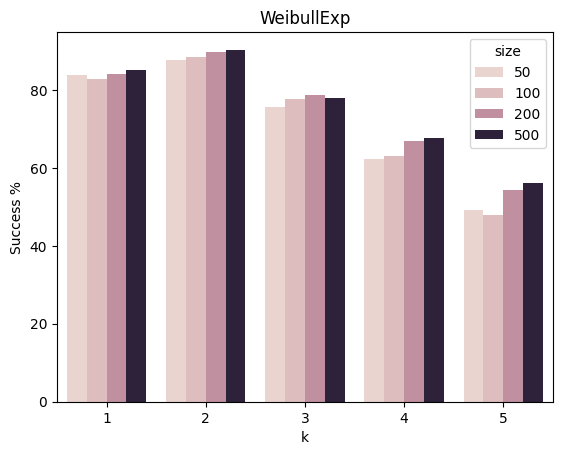

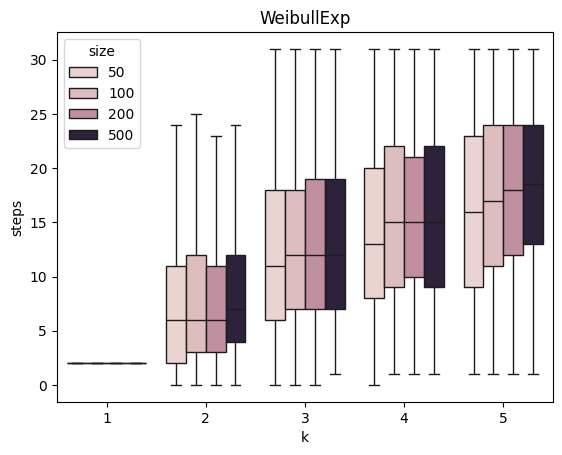

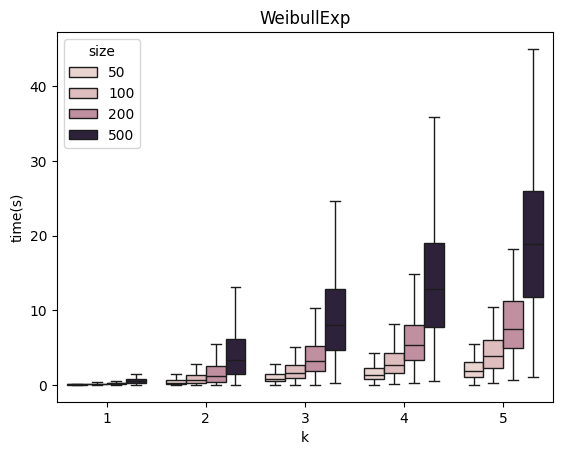

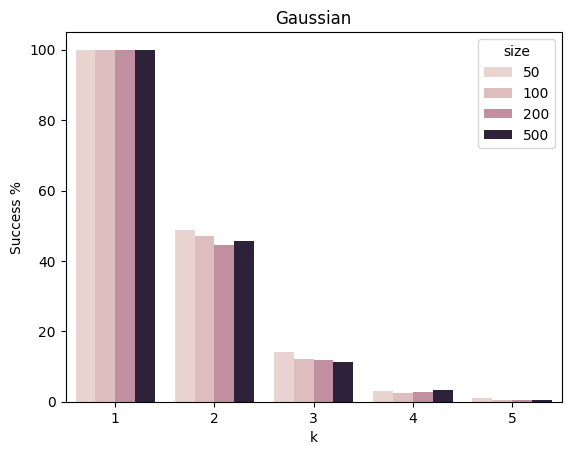

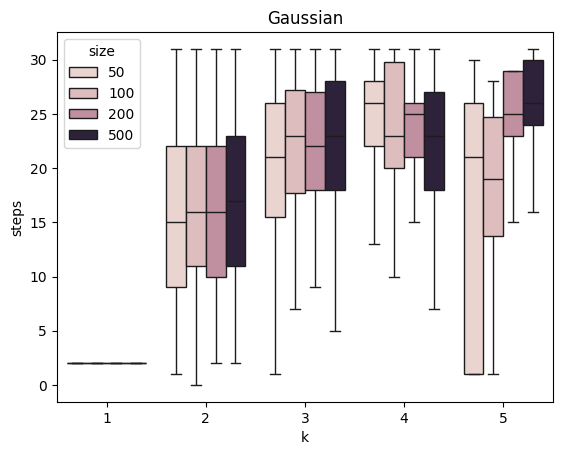

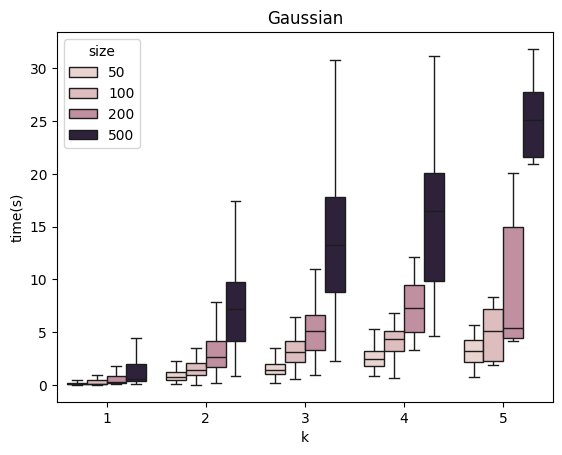

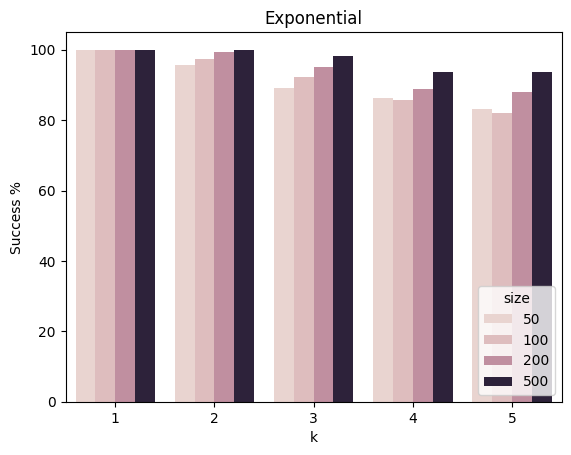

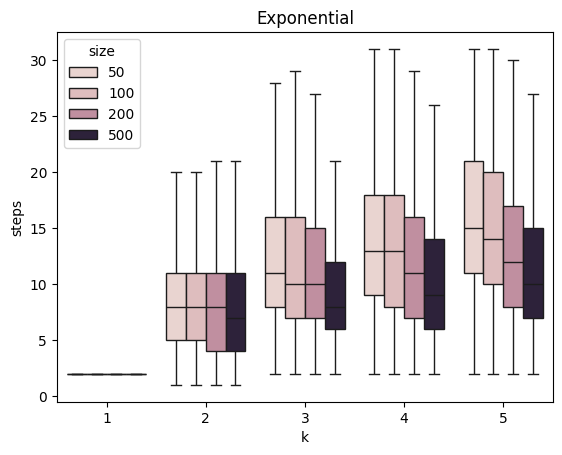

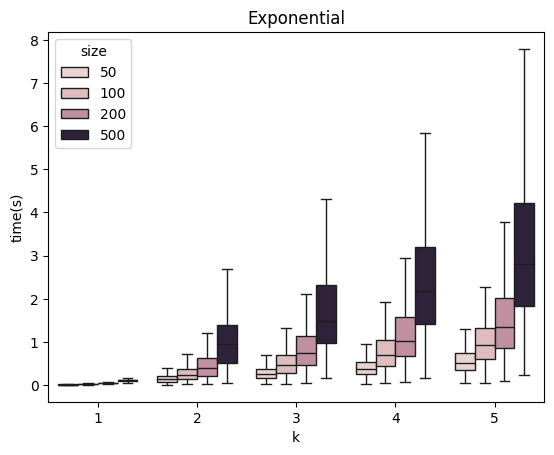

In [6]:
for model in results_data.keys():
    data = results_data[model]
    sns.barplot(data, x="k", y="success", hue="size")
    plt.xlabel("k")
    plt.ylabel("Success %")
    plt.title(model.name())
    """
    if model is GaussianModel:
        plt.legend(loc='upper right', title="size")
    else:
        plt.legend(loc='lower left', title="size")
        """
    if model is ExponentialModel:
        plt.legend(loc='lower right', title="size")
    plt.show()

    plt.title(model.name())
    sns.boxplot(data=data, x="k", y="steps", hue="size", showfliers=False)
    plt.show()

    plt.title(model.name())
    sns.boxplot(data=data, x="k", y="time", hue="size", showfliers=False)
    plt.ylabel("time(s)")
    plt.show()